# CoinFlip Randomization.

In each node, we flip a coin that becomes the gating function. So the splitting value is irrelevant. The only thing that matters are the ratios in which the incoming instances are split.

This is obviously a bit simplistic, since there is no longer any reference to the feature value anymore. We will have to deal with this another time. However, if you regard the decision tree as some kind of observations of the original dataset, it does make sense that it is binomial. Given the previous splits, we should see a splitting up of the instances in some ratios.



## Imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.datasets import (make_friedman1,
                              make_friedman2,
                              make_friedman3)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

note_dir = os.getcwd()
root_dir = os.path.dirname(note_dir)
sys.path.append(root_dir)

import bonsai
from bonsai.base import *

In [2]:
def plot_corr(corr):
    fig = plt.figure(figsize=((10,10))) # slightly larger
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax)
    
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='w')
    return 

In [3]:
def summarize_dataset(df, samples=1000, random_state=997, replace=False):
    """
    This function plots a grid of plots that give some insights into pairwise relationships between
    the attributes in the dataset.
    
    Explicit correlations or special distributions should be very visible here.
    """
    
    df_subsample = df.sample(n=samples, replace=False, random_state=random_state)
    
    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df_subsample) # slice every 10 otherwise a bit slow
    g = g.map_diag(plt.hist) # histograms on the diagonal
    g = g.map_lower(sns.kdeplot, cmap="Blues_d") # density plot on the lower plots
    g = g.map_upper(plt.scatter) # scatter plots on the upper plots
    return

## Try Building Distributed Dataset

Artificial dataset with specific output shape, so I can check the distributions that I sample somehow resemble the real thing

In [4]:
# Synthetic DataSet using sklearn
X_1, y_1 = make_friedman1(n_samples=10**4, n_features=5, noise=1.0) 
X_2, y_2 = make_friedman1(n_samples=10**4, n_features=5, noise=1.0) 

X_2 += 0.25
y_2 += 30 # Bimodal Outcome

X = np.concatenate((X_1, X_2))

X_train, X_test, y_train, y_test = train_test_split(np.concatenate((X_1, X_2)),
                                                    np.concatenate((y_1, y_2)),
                                                    test_size=0.2)

train_data = np.concatenate((X_train, np.atleast_2d(y_train).T), axis=1)
test_data = np.concatenate((X_test, np.atleast_2d(y_test).T), axis=1)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

X_train, X_test, y_train, y_test = train_data[:, 0:-1], test_data[:, 0:-1], train_data[:, -1:][:,0], test_data[:,-1:][:,0]

In [5]:
df = pd.DataFrame(X_train)
df = df.assign(y=y_train)
df.head()

,0,1,2,3,4,y
0,0.604399,1.067460,1.162065,0.754436,0.638626,48.470522
1,0.493971,0.441279,1.042147,0.587260,0.381395,38.487325
2,1.121719,0.639264,0.474031,0.753417,0.582557,47.798211
3,0.631838,0.173469,0.167407,0.560957,0.203962,12.088947
4,0.150286,0.189642,0.384788,0.016889,0.504020,4.494302


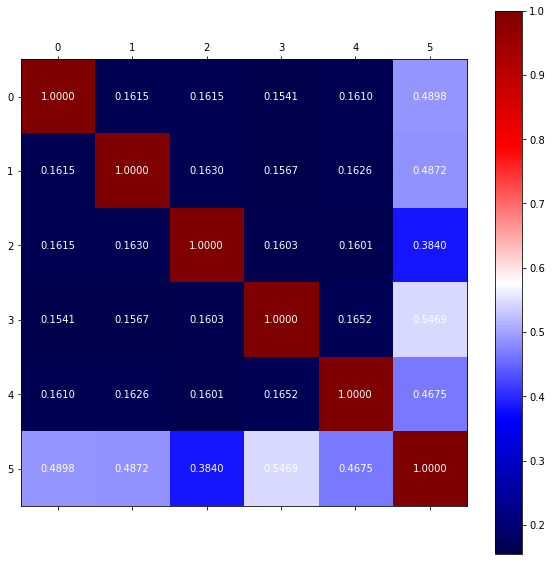

In [6]:
corr = df.corr().values
plot_corr(corr)

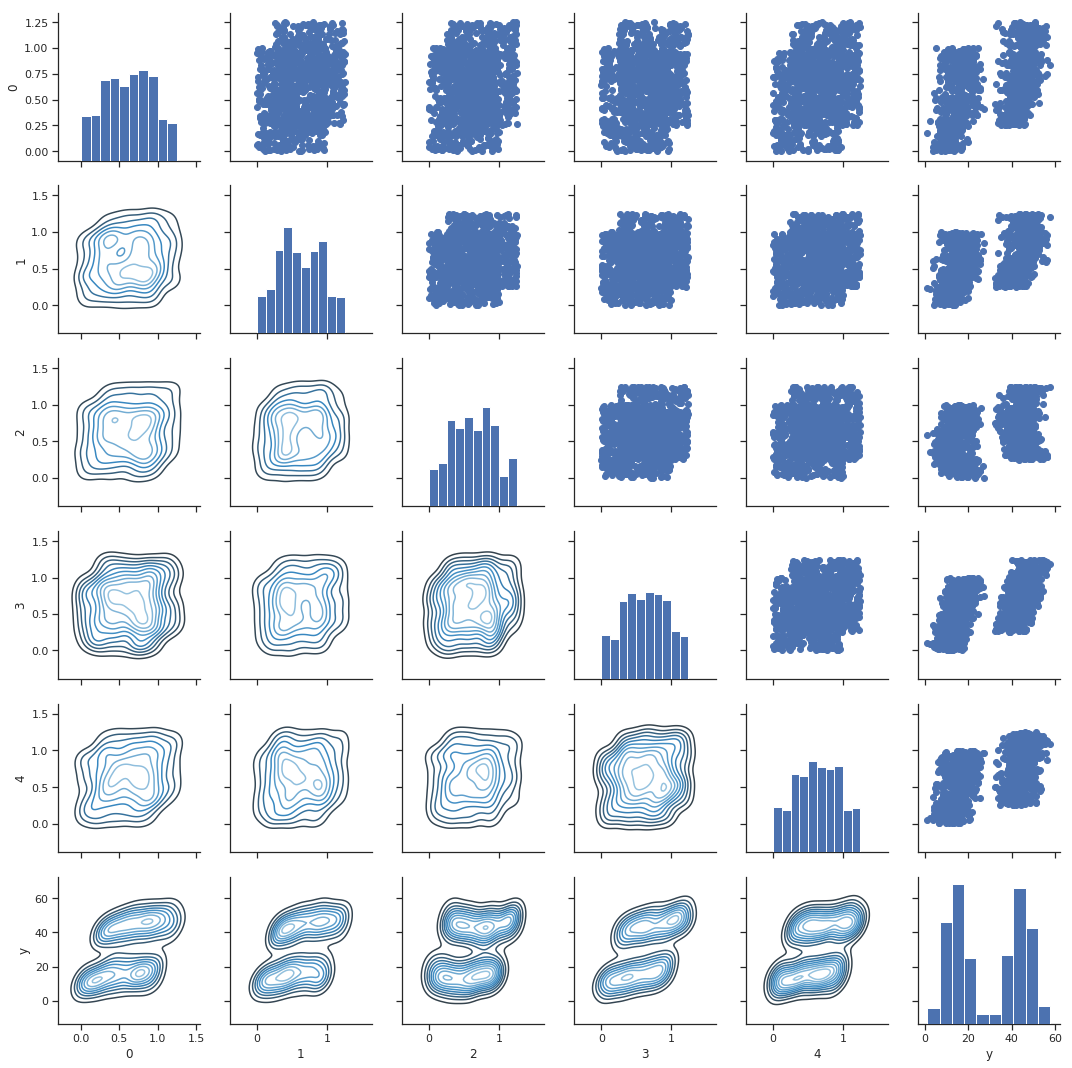

In [7]:
summarize_dataset(df, samples=1000)

## Build Tree

In [8]:
# Initialize
model = RegTree(max_depth=15)

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

rmse_original = np.sqrt(np.mean((y_test - y_pred)**2))
rmse_original


7.623631542579628

The ideal outcome, bimodal so our tree does not learn this


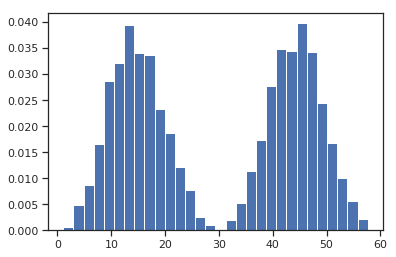

In [9]:
plt.hist(y_test, 30, density=True)
print("The ideal outcome, bimodal so our tree does not learn this")
plt.show()

Our outcome, rmse minimalization focuses on the intermediate area for no reason


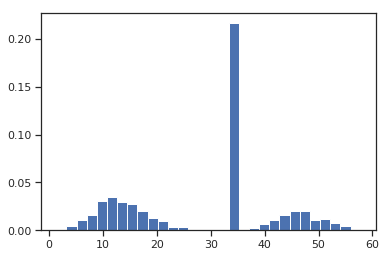

In [10]:
plt.hist(y_pred, 30, density=True)
print("Our outcome, rmse minimalization focuses on the intermediate area for no reason")
plt.show()

In [28]:
derived_trees = [model.randomize_tree(kind="swap") for _ in range(500)]
derived_pred = [m.predict(X_test) for m in derived_trees]
derived_rmse = [np.sqrt(np.mean((y_test - y_pred)**2)) for y_pred in derived_pred]
delta_rmse = [rmse_original-d for d in derived_rmse]

mean_pred = np.mean(derived_pred, axis=0)
rmse_mean = np.sqrt(np.mean((y_test - mean_pred)**2))
print(rmse_mean)

8.880801938431665


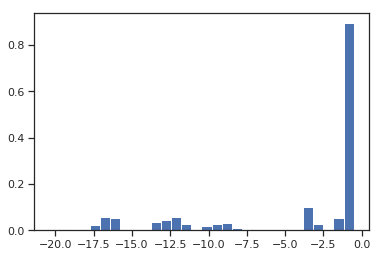

In [29]:
plt.hist(delta_rmse, 30, density=True)
plt.show()

Our sampled outcomes


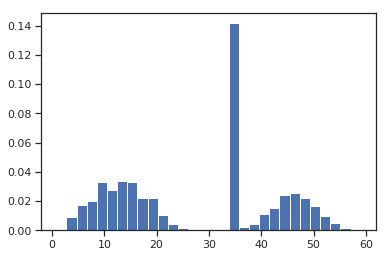

In [14]:
X_test[[10]]

array([[0.63633551, 0.90901881, 0.64804407, 0.83986045, 0.42514068]])

In [15]:
test_tuple = np.array([[0.5, 0.5, 0.5, 0.5, 0.5]])

Sampling a test-tuple


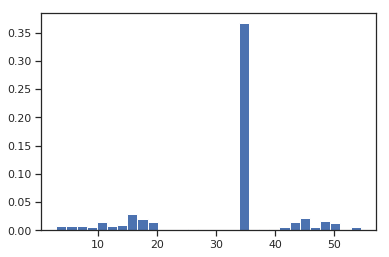

In [34]:
plt.hist(np.array([m.predict(np.array([[0.4, .4, .4, .4, .4]])) for m in derived_trees]), 30, density=True)
print("Sampling a test-tuple")
plt.show()

Sampling a test-tuple


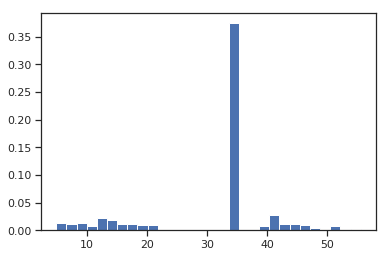

In [37]:
plt.hist(np.array([m.predict(np.array([[0.9, 0.9, 0.9, 0.9, 0.9]])) for m in derived_trees]), 30, density=True)
print("Sampling a test-tuple")
plt.show()

In [18]:
model.predict(np.array([[0.6, .6, .6, .6, .6]]))

array([35.14391852])

## Check outcome probability

In [19]:
X_test[[10]]

array([[0.63633551, 0.90901881, 0.64804407, 0.83986045, 0.42514068]])

In [20]:
model.predict(X_test[[10]])

array([35.14391852])

In [21]:
derived_pred = [m.predict(X_test[[10]]) for m in derived_trees]